# AutoML Tutorials with Autogluon

## Get started in Colab<a class="anchor" id="1"></a>
1. Klicke auf [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/AutoML_Tutorials.ipynb) um dieses Notebook als Session in Colab zu starten.
<br/>--In Colab--

2. Klicke auf Laufzeit > Laufzeittyp ändern > T4 GPU > Speichern
3. Führe die nächste Zelle aus um die benötigten Daten in die Session zu laden und um benötigte Requirements zu installieren. Diese benötigt ca 5-6 min.
4. Klicke anschließend im Output der Zelle auf "Restart Session".

In [ ]:
!wget -q -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/Bike_Sharing_Webinar.csv
!wget -q -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/CWRU.csv
!wget -q -P ./data https://github.com/IIS-KI-Tutorials/KI-Tutorials/raw/main/data/Metallgussteile.zip
!unzip -q ./data/Metallgussteile.zip -d ./data
!rm ./data/Metallgussteile.zip
!pip install -q autogluon

-------------AB HIER BEGINNEN DIE EIGENTLICHEN TUTORIALS--------------------


## Inhaltsverzeichnis
1. **Fahrrad Sharing - Regression mit tabellarischen Daten**<br/>
Ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von tabellarischen Daten trainiert.
Ziel ist es, die Nachfrage nach Leihfahrrädern für einen Tag anhand verschiedener Informationen wie Wochentag, Wetterbedingungen etc. vorherzusagen.
2. **Fehlerhafte Kugellager - Klassifikation auf Zeitreihendaten** <br/>
Ein einfaches Beispiel, wie man mittels AutoML Klassifikation von Zeitreihendaten durchführen kann. Ziel ist es, verschiedene Fehlertypen zu klassifizieren, welche bei einem Kugellager auftreten können.
3. **Metallgussteile - Klassifikation mit Bilddaten**<br/>
Ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von Bilddaten trainiert.
Ziel ist es, eine automatische Qualitätskontrolle für Metallgussteile zu entwickeln.

## 1. Fahrrad Sharing - Regression mit tabellarischen Daten <a class="anchor" id="2"></a>

Dieses Notebook ist ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von tabellarischen Daten trainiert.
Ziel ist es, die Nachfrage nach Leihfahrrädern für einen Tag anhand verschiedener Informationen wie Wochentag, Wetterbedingungen etc. vorherzusagen.
Die Zielvariable ist also eine kontinuierliche Größe, weshalb wir in diesem Fall von einem Regressionsproblem sprechen.

### Inhaltsverzeichnis
1. [Importiere AutoML Framework - AutoGluon](#2_1)<br/>
2. [Laden der Daten](#2_2)<br/>
3. [Merkmal- und Labelauswahl](#2_3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#2_4)<br/>
5. [Modell Training](#2_5)<br/>
6. [Modell Test](#2_6)<br/>
7. [Model Interpretation](#2_7)<br/>
8. [Modell exportieren/speichern](#2_8)<br/>
9. [Modell laden](#2_9)<br/>
10. [Vorhersagen für neue Daten](#2_10)<br/>

### 1 Importiere AutoML Framework - AutoGluon <a class="anchor" id="2_1"></a>
In diesem Beispiel verwenden wir das AutoML-Framework AutoGluon. Da es sich bei dem Datensatz um tabellarische Daten handelt, benötigen wir für die Bearbeitung des vorliegenden Problems  lediglich die Klassen `TabularDataset` und `TabularPredictor`, welche wir hier importieren. Darüber hinaus importieren wir ebenso die Bibliothek `matplotlib` für spätere Visualisierungen.

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt # Bibliothek für Visualisierungen

### 2 Laden der Daten <a class="anchor" id="2_2"></a>
Als nächstes laden wir die Daten mit Hilfe der `TabularDataset` Klasse und speichern sie in der Variable `data`. Mittels der `head()` Methode können wir uns die ersten 5 Instanzen des Datensatzes anzeigen lassen. Dadurch erhalten wir einen Einblick, wie unsere Daten ausschauen. Allgemeine Informationen zum Datensatz sind unter foldendem Link zu finden: [https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [2]:
data = TabularDataset('./data/Bike_Sharing_Webinar.csv')
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,winter,0,1,0,saturday,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,winter,0,1,0,sunday,0,2,NaN,NaN,NaN,NaN,131,670,801
2,2011-01-03,winter,0,1,0,monday,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,winter,0,1,0,tuesday,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,winter,0,1,0,wednesday,1,1,NaN,NaN,NaN,NaN,82,1518,1600


Im Folgenden sehen wir die Auflistung aller Merkmale und Label.
Es sei zu beachten, dass es sowohl kategorische (season und weekday) als auch numerische Merkmale (yr, mnth, ...) gibt.
Teilweise gibt es auch fehlende Messwerte (s. NaN).
Außerdem sei anzumerken, dass es insgesamt drei Label gibt.

Merkmale:
- **dteday**: Datum
- **season**: Jahreszeit
- **yr**: Jahr
    - 0: 2011
    - 1: 2012
- **mnth**: Monat (1 bis 12)
- **holiday**: Feiertag?
    - nein: 0
    - ja: 1
- **weekday**: Wochentag
- **workingday**:
    - 1: wenn weder Wochenende noch Feiertag
    - 0: sonst
- **weathersit**:
    - 1: klar, leicht/teilweise bewölkt
    - 2: bewölkt, Nebel
    - 3: leichter Regen/Schnee, Gewitter
    - 4: starker Regen/Schnee, Sturm
- **temp**: Temperatur (normalisiert)
- **atemp**: gefühlte Temperatur (normalisiert)
- **hum**: Luftfeuchtigkeit
- **windspeed**: Windgeschwindigkeit (normalisiert)

Label:
- **casual**: Anzahl der nicht-registrierten Nutzer
- **registered**: Anzahl der registrierten Nutzer
- **cnt**: Gesamtzahl der Nutzern

### 3 Merkmal- und Labelauswahl <a class="anchor" id="2_3"></a>
Damit das AutoML Framework später ein Modell trainieren kann, müssen wir zunächst angeben, welche der Spalten Merkmale repräsentieren und welche die Label. Für den Moment wollen wir `casual` als Label wählen, d.h. wir wollen also die Anzahl der nicht-registrierten Nutzer pro Tag vorhersagen. Bei den Merkmalen lassen wir das Datum weg, da wir schon über die Spalten 'yr', 'mnth' sowie 'weekday' verfügen.

In [3]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
label = 'casual'

Um ein besseres Verständnis über die Daten zu erlangen, wollen wir nun das ausgewählte Label über die Zeit plotten. Hier wird z.B. deutlich, dass es einen merklichen saisonalen Effekt gibt. Die Nachfrage nach Fahrrädern ist also im Sommer höher als im Winter. Auch gibt es deutliche Schwankungen innerhalb einer Woche. So zeigt sich, dass die Anzahl der nicht-registrierten Nutzer vor allem am Wochende hoch ist, während sie unter der Wocher deutlich geringer ausfällt.

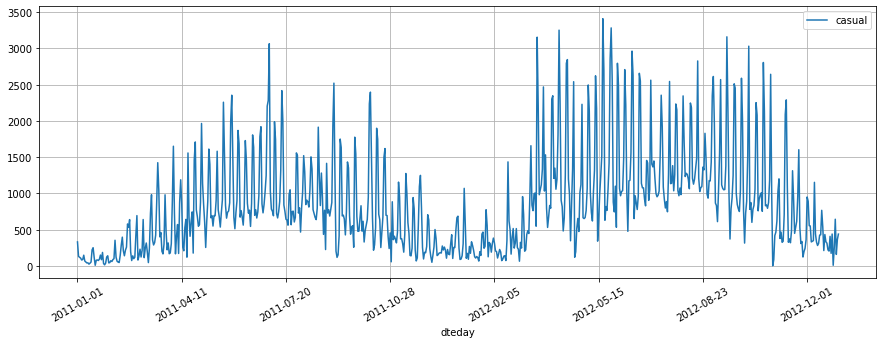

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
data.plot('dteday', label, rot=30, ax=ax)
plt.grid()

### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="2_4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testset.

Die ersten 80% der Daten werden als Trainingsdaten und die letzten 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

In [5]:
train_size = round(0.8 * len(data))

all_columns =  features + [label]

data_train = data.loc[:train_size, all_columns]
data_test = data.loc[train_size:, all_columns]

### 5 Modell Training <a class="anchor" id="2_5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen der Zielvariable angeben (Diese haben wir vor einigen Zellen bereits in der Variable `label` gespeichert).
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Fahrrad_Sharing").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Regressionsproblem handelt.
Auch erkennt es die verschiedenen Datentypen der vorhandenen Merkmale und kodiert etwa die kategorischen Label automatisch in numerische um.

In [6]:
predictor = TabularPredictor(label=label, path='AutogluonModels/Fahrrad_Sharing')
predictor.fit(data_train);

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/Fahrrad_Sharing\"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    586
Train Data Columns: 11
Label Column: casual
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (3410, 9, 811.36689, 676.6872)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5825.05 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify 

Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich den RMSE (Wurzel des mittleren quadratischen Fehlers) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird darüber hinaus ein Diagramm erstellt, welches unter dem Pfad "AutogluonModels/Fahrrad_Sharing/SummaryOfModels.html" zu finden ist.

In [7]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -212.910530       0.062016  30.398674                0.000000           0.571019            2       True         12
1            LightGBMXT -218.646536       0.006004   1.844259                0.006004           1.844259            1       True          3
2              CatBoost -223.832761       0.012008  20.095408                0.012008          20.095408            1       True          6
3              LightGBM -234.448532       0.007004   0.394001                0.007004           0.394001            1       True          4
4               XGBoost -243.646787       0.012999   1.685387                0.012999           1.685387            1       True          9
5         ExtraTreesMSE -244.419023       0.119004   0.595591                0.119004           0.

### 6 Modell Test <a class="anchor" id="2_6"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.

Zunächst benutzen wir die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der `predictions` Variable.

Außerdem nutzen wir die `evaluate()` Methode, um eine Reihe von Qualitätsmaßen zu berechnen (wie etwa RMSE, MSE etc.). 

In [8]:
predictions = predictor.predict(data_test)
pred_metrics = predictor.evaluate(data_test)

Evaluation: root_mean_squared_error on test data: -263.6526756498307
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -263.6526756498307,
    "mean_squared_error": -69512.73337731483,
    "mean_absolute_error": -182.40001690224426,
    "r2": 0.8597284736250072,
    "pearsonr": 0.9272803884899582,
    "median_absolute_error": -119.67518615722656
}


Hier sehen wir abermals eine Überischt aller trainierten Modelle. Die Tabelle beinhaltet jetzt auch die Spalte "score_test". Diese zeigt den jeweiligen RMSE auf den Testdaten.

In [9]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-263.652676,-212.910530,0.152997,0.062016,30.398674,0.015999,0.000000,0.571019,2,True,12
1,CatBoost,-277.101407,-223.832761,0.008999,0.012008,20.095408,0.008999,0.012008,20.095408,1,True,6
2,LightGBMXT,-279.669992,-218.646536,0.021999,0.006004,1.844259,0.021999,0.006004,1.844259,1,True,3
3,LightGBM,-295.540703,-234.448532,0.016999,0.007004,0.394001,0.016999,0.007004,0.394001,1,True,4
4,NeuralNetTorch,-295.741319,-293.297027,0.050003,0.024001,5.808600,0.050003,0.024001,5.808600,1,True,10
5,RandomForestMSE,-311.101361,-250.066254,0.225657,0.056379,0.778896,0.225657,0.056379,0.778896,1,True,5
6,ExtraTreesMSE,-311.207706,-244.419023,0.167003,0.119004,0.595591,0.167003,0.119004,0.595591,1,True,7
7,LightGBMLarge,-314.317332,-256.675190,0.023001,0.010001,1.049668,0.023001,0.010001,1.049668,1,True,11
8,XGBoost,-327.450622,-243.646787,0.038998,0.012999,1.685387,0.038998,0.012999,1.685387,1,True,9
9,NeuralNetFastAI,-377.800826,-309.892033,0.045002,0.046003,4.224016,0.045002,0.046003,4.224016,1,True,8


Nun wollen wir die Ergebnisse visualisieren. In folgendem Plot sieht man sowohl die tatsächliche Nachfrage als auch unsere vom Modell vorhergesagte Nachfrage über die Zeit.

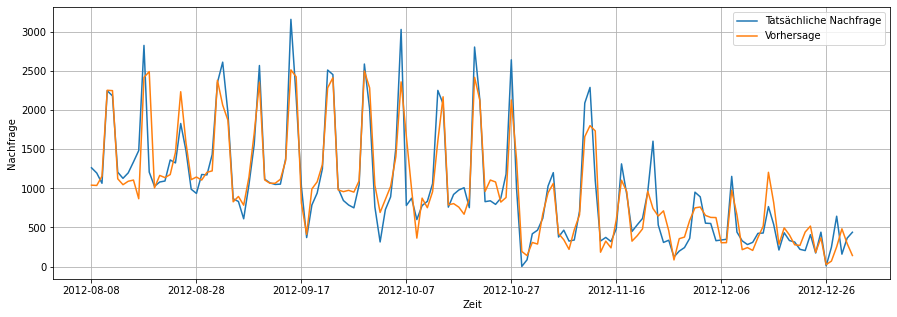

In [10]:
data_test[f'{label}_prediction'] = predictions
data_test['dteday'] = data.loc[train_size:, 'dteday']

fig, ax = plt.subplots(figsize=(15, 5))
data_test.plot(x="dteday", y=[f"{label}", f"{label}_prediction"], xlabel="Zeit", ylabel="Nachfrage", style='-', ax=ax)
plt.grid()
ax.legend(["Tatsächliche Nachfrage", "Vorhersage"]);

### 7 Model Interpretation <a class="anchor" id="2_7"></a>
In der folgenden Zelle wird die sog. Merkmalswichtigkeit (engl.: feature importance) berechnet und aufgelistet. Je höher die Wichtigkeit (importance), desto einflussreicher ist das jeweilige Merkmal bei der Bestimmung einer Vorhersage. Dies kann sehr aufschlussreich sein und trägt zum besseren Verständnis der Daten bei.

In [11]:
predictor.feature_importance(data_test, silent=True)

These features in provided data are not utilized by the predictor and will be ignored: ['casual_prediction', 'dteday']


,importance,stddev,p_value,n,p99_high,p99_low
workingday,382.163089,38.026814,0.000012,5,460.460825,303.865353
atemp,165.672754,11.539724,0.000003,5,189.433206,141.912302
temp,123.766290,17.652857,0.000048,5,160.113766,87.418814
weekday,56.122823,3.629811,0.000002,5,63.596653,48.648992
hum,53.919458,11.996290,0.000276,5,78.619984,29.218932
windspeed,49.950801,11.929401,0.000362,5,74.513602,25.388000
weathersit,24.876758,6.085258,0.000397,5,37.406388,12.347128
mnth,12.268432,3.001202,0.000397,5,18.447949,6.088916
season,4.387990,2.228876,0.005836,5,8.977277,-0.201296
holiday,0.409046,0.168853,0.002814,5,0.756716,0.061376


### 8 Modell exportieren/speichern <a class="anchor" id="2_8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern.

In [12]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/Fahrrad_Sharing\")


### 9 Modell laden <a class="anchor" id="2_9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [13]:
predictor = TabularPredictor.load(path="./AutogluonModels/Fahrrad_Sharing")

### 10 Vorhersagen für neue Daten <a class="anchor" id="2_10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [14]:
test_day = data.sample() # eine zufällige Instanz wird aus dem Datensatz gezogen
test_day

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
628,2012-09-20,summer,1,9,0,thursday,1,1,0.546667,0.532192,0.618333,0.118167,939,6781,7720


In [15]:
prediction = predictor.predict(test_day)
print(f'Vorhergesagte Nachfrage ({label}): {round(prediction.values[0])} Fahrräder')

Vorhergesagte Nachfrage (casual): 1083 Fahrräder


## 2. Fehlerhafte Kugellager - Klassifikation auf Zeitreihendaten<a class="anchor" id="3"></a>

Dieses Tutorial zeigt ein einfaches Beispiel, wie man mittels AutoML Klassifikation von Zeitreihendaten durchführen kann. Ziel ist es, verschiedene Fehlertypen zu klassifizieren, welche bei einem Kugellager auftreten können.

### Inhaltsverzeichnis
1. [Imports](#3_1)<br/>
2. [Laden der Daten](#3_2)<br/>
3. [Fenstern der Daten und Berechnen von Merkmalen](#3_3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#3_4)<br/>
5. [Modell Training](#3_5)<br/>
6. [Modell Test](#3_6)<br/>
7. [Modell Interpretation](#3_7)<br/>
8. [Modell exportieren/speichern](#3_8)<br/>
9. [Modell laden](#3_9)<br/>
10. [Vorhersagen für neue Daten](#3_10)<br/>

### 1 Imports <a class="anchor" id="3_1"></a>

In [ ]:
# --- 3rd party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

Wir benötigen noch ein zwei Funtionen.
1. get_windows: Die Funktion bekommt eine Zeitreihe als numpy Array und gibt uns eine gefensterte Version der Zeitreihe zurück.
2. train_test_split_stratified: Teilt die Daten in Train und Test Datasets, sodas der prozentualle Anteil jeder Klasse in beiden Datasets möglichs ähnlich ist.

In [ ]:
def get_windows(arr: np.ndarray, window_size: int, step_size: int) -> np.ndarray:
    """
    Window a 1D-array into windows of given size and with given step size.

    Parameters
    ----------
    arr : np.ndarray
        1D input array.
    window_size : int
        Window size in number of samples.
    step_size : int
        Step size in number of samples

    Returns
    -------
    output_array: np.ndarray
        2D output array of shape (n_windows, window_size)

    Examples
    --------
    >>> a = np.arange(6)
    >>> a
    array([0, 1, 2, 3, 4, 5])
    >>> get_windows(a, window_size=3, step_size=1)
    array([[0, 1, 2],
           [1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    """
    assert arr.ndim == 1

    n_rows = ((arr.size - window_size) // step_size) + 1
    n = arr.strides[0]

    return np.lib.stride_tricks.as_strided(arr, shape=(n_rows, window_size), strides=(step_size*n, n))


def train_test_split_stratified(df: pd.DataFrame, test_size: float, label_colname: str):
    """
    Splits a dataframe into a train and test dataframe in a stratified fashion (according to the given label).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    test_size : float
        Should be between 0.0 and 1.0 and represents the proportion of the dataset to include in the test split.
    stratify : str
        Key of the label column in the input dataframe. Stratification will be done according to the values in this column.

    Returns
    -------
    splitting : tuple, length=2
        Tuple containing the train and test split of the input dataframe.
    """
    df_train = df.groupby(label_colname, group_keys=False).apply(
        lambda x: x.sample(int(np.rint(int(round(len(df) * (1 - test_size))) * len(x) / len(df))))).sample(frac=1)
    df_test = df.drop(index=df_train.index)
    
    return df_train, df_test

### 2 Laden der Daten <a class="anchor" id="3_2"></a>

Bearing Data Center vom CWRU

Original-Datensatz: [https://engineering.case.edu/bearingdatacenter/download-data-file](https://engineering.case.edu/bearingdatacenter/download-data-file)

![](../assets/CWRU_ilustration.png)

Diese Motorlagerexperimente wurden initiiert, um die Leistung von IQ PreAlert, einem bei Rockwell entwickelten Motorlager-Zustandsbewertungssystem, zu charakterisieren. Experimente wurden unter Verwendung eines 2-PS-Reliance-Elektromotors durchgeführt, und Beschleunigungsdaten wurden an Antriebs- und Lüftungsseite der Motorlager gemessen. Diese Motorlager wurden durch Elektroentladungsbearbeitung (EDM) mit Fehlern übersät. Fehler im Bereich von 0,007 Zoll Durchmesser bis 0,040 Zoll Durchmesser wurden separat an der inneren Laufbahn, dem Walzkörper (d. h. der Kugel) und der äußeren Laufbahn eingeführt. Fehlerhafte Lager wurden wieder in den Testmotor eingebaut und Vibrationsdaten mit einer Frequenz von 12 kHz aufgezeichnet.

Die Sensoren sind:
* Antriebsseite: acc0
* Lüftungsseite: acc1

Die Recording IDs sind wie folgt aufgebaut:
* Der erste Wert gibt den Ort des Fehlers an:
    * none: Kein Fehler
    * OR: Outer Race (Außenbahn)
    * IR: Inner Race (Innenbahn)
    * BA: Ball (Kugel)
* Der Zahlenwert definiert die Schwere des Fehlers (bzw. den Durchmesser):
    * 00: Kein Fehler
    * 07: 0.007''
    * 14: 0.014''
    * 21: 0.021''

Wir laden die Daten als sog. DataFrame und speichern sie in der Variablen `data`.

Der Datensatz beinhaltet mehr als 1,5 Mio. Messpunkte (Instanzen).
Neben der Zeitspalte sehen wir die beiden Beschleunigungssensoren ("acc0" und "acc1") sowie die Spalte "recording_id".
Es gibt insgesamt 10 verschiedene recording_ids, von denen jede eine einzelne Messung repräsentiert.
Da pro Messung immer nur ein bestimmter Fehler vorhanden war, entspricht dies im Grunde der Label-Spalte.

In [ ]:
data = pd.read_csv("./data/CWRU.csv")
data

,time,acc0,acc1,recording_id
0,0.000000,0.105420,0.204633,BA_14
1,0.000083,-0.107370,0.248395,BA_14
2,0.000167,-0.163410,0.042324,BA_14
3,0.000250,0.118903,-0.015615,BA_14
4,0.000333,0.184039,-0.058555,BA_14
...,...,...,...,...
1584628,10.165583,-0.156344,0.063691,IR_21
1584629,10.165667,1.099280,-0.059376,IR_21
1584630,10.165750,0.231876,-0.080949,IR_21
1584631,10.165833,-1.241410,0.110945,IR_21


In [ ]:
unique_recording_ids = sorted(data['recording_id'].unique())
print(f'Liste der vorkommenden recording_ids bzw. Label:\n\n{", ".join(unique_recording_ids)}')

Liste der vorkommenden recording_ids bzw. Label:

BA_07, BA_14, BA_21, IR_07, IR_14, IR_21, OR_07, OR_14, OR_21, none_00


### 3 Fenstern der Daten und Berechnen von Merkmalen <a class="anchor" id="3_3"></a>
In diesem Beispiel handelt es sich um sog. Zeitreihendaten, die mit einer Frequenz von 12 kHz aufgenommen wurden.
Ein einzelner Messpunkt für sich trägt hierbei keine wertvolle Information, sondern vielmehr ist die Abfolge von Messpunkten im zeitlichen Kontext interessant und für das entsprechende Label charakteristisch.

Im Folgenden wollen wir also zunächst die vorhandenen Rohdaten fenstern. Hierzu ist es notwendig eine Fenstergröße zu definieren (window_length). Anschließend werden statistische Merkmale (Minimum, Maximum, Mittelwert, ...) auf den Daten innerhalb der jeweiligen Fenster berechnet. Je nach recording_id ist jedem Fenster außerdem auch ein Label zugeordnet.

In [ ]:
window_length = 0.1 # in seconds

window_size = round(window_length * 12000) # 12000/s ist die Abtastrate der Sensoren
feature_names = ['min', 'max', 'range', 'mean', 'median']
sensors = ['acc0', 'acc1']
feature_dict = {f'{sensor}_{feature_name}': [] for sensor in sensors for feature_name in feature_names}
feature_dict['label'] = []

for recording_id in data['recording_id'].unique():
    for sensor in sensors:
        windowed_data = get_windows(data[data['recording_id'] == recording_id][sensor].values, window_size, window_size)

        feature_dict[f'{sensor}_min'] += [min(row) for row in windowed_data]
        feature_dict[f'{sensor}_max'] += [max(row) for row in windowed_data]
        feature_dict[f'{sensor}_range'] += list(np.array([min(row) for row in windowed_data]))
        feature_dict[f'{sensor}_mean'] += [np.mean(row) for row in windowed_data]
        feature_dict[f'{sensor}_median'] += [np.median(row) for row in windowed_data]
        
    feature_dict['label'] += [recording_id for i in range(len(windowed_data))]

data_features = pd.DataFrame.from_dict(feature_dict)

In der folgenden Zelle sehen wir nun das Resultat unserer Merkmalsberechnung. Jede Zeile der Tabelle repräsentiert nun ein vorher ausgeschnittenes Fenster (von vorher definierter Länge) auf dem verschiedene statistische Merkmale berechnet wurden. Die Spalten stehen für eben jene berechneten Merkmale. Die letzte Spalte zeigt das dem Fenster zugeordnete Label.

In [ ]:
data_features

,acc0_min,acc0_max,acc0_range,acc0_mean,acc0_median,acc1_min,acc1_max,acc1_range,acc1_mean,acc1_median,label
0,-0.462940,0.461153,-0.462940,0.004501,0.001218,-0.371256,0.443987,-0.371256,0.031285,0.036263,BA_14
1,-0.409012,0.475935,-0.409012,0.004824,0.005685,-0.364887,0.426729,-0.364887,0.032116,0.032565,BA_14
2,-1.048844,1.105858,-1.048844,0.004549,0.003574,-0.389953,0.474189,-0.389953,0.031660,0.035338,BA_14
3,-0.830206,0.733395,-0.830206,0.004575,0.008853,-0.568904,0.537880,-0.568904,0.031400,0.034619,BA_14
4,-0.365154,0.464889,-0.365154,0.004456,0.005279,-0.347835,0.405362,-0.347835,0.032805,0.035441,BA_14
...,...,...,...,...,...,...,...,...,...,...,...
1310,-2.438151,2.682616,-2.438151,0.001187,-0.006091,-0.742718,0.798396,-0.742718,0.030567,0.029894,IR_21
1311,-2.190844,2.725255,-2.190844,0.003245,-0.008122,-0.782371,0.657455,-0.782371,0.031778,0.031640,IR_21
1312,-2.058459,2.397136,-2.058459,0.002297,-0.005076,-0.646976,0.750525,-0.646976,0.031111,0.024141,IR_21
1313,-2.680992,3.030633,-2.680992,0.002782,-0.005482,-0.713338,0.710462,-0.713338,0.032110,0.035030,IR_21


### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="3_4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testdaten.

80% der Daten werden als Trainingsdaten und 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

Die Daten werden hierbei so getrennt, dass die Verteilung der Label sowohl in Trainings- als auch Testset der Verteilung der Label in den Gesamtdaten entspricht.

In [ ]:
data_train, data_test = train_test_split_stratified(data_features, test_size=0.2, label_colname='label')

### 5 Modell Training <a class="anchor" id="3_5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen des Labels angeben.
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Kugellager").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Klassifikationsproblem handelt.

In [ ]:
predictor = TabularPredictor(label='label', path='AutogluonModels/Kugellager')
predictor.fit(data_train);

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/Kugellager\"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    1054
Train Data Columns: 10
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	10 unique label values:  ['BA_07', 'none_00', 'IR_07', 'BA_14', 'IR_14', 'OR_21', 'OR_07', 'IR_21', 'BA_21', 'OR_14']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 10
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5634.59 MB
	Train Data (Original)  Memory Usage: 0.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set fea

Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich die Genauigkeit (engl.: accuracy) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird zudem ein Diagramm erstellt, in dem die Inferenzzeit und die Modellgenauigkeit gegenübergestellt werden. Dieses wird im Pfad "AutogluonModels/Kugellager/SummaryOfModels.html" abgespeichert und kann in einem Browser geöffnet werden.

In [ ]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.981043       0.044962   6.603499                0.001000           0.344003            2       True         14
1               XGBoost   0.976303       0.008961   1.311018                0.008961           1.311018            1       True         11
2         LightGBMLarge   0.971564       0.020005   5.908095                0.020005           5.908095            1       True         13
3            LightGBMXT   0.971564       0.024008   3.521878                0.024008           3.521878            1       True          4
4              LightGBM   0.962085       0.022004   3.557263                0.022004           3.557263            1       True          5
5       NeuralNetFastAI   0.962085       0.035002   4.948477                0.035002           4.948477 

### 6 Modell Test <a class="anchor" id="3_6"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.
Mit der `evaluate` Methode können wir eine Reihe von Qualitätsmaßen berechnen.

In [ ]:
pred_metrics = predictor.evaluate(data_test)

Evaluation: accuracy on test data: 0.9540229885057471
Evaluations on test data:
{
    "accuracy": 0.9540229885057471,
    "balanced_accuracy": 0.9399999999999998,
    "mcc": 0.9463219985617793
}


Hier sehen wir abermals eine Überischt aller trainierten Modelle. Die Tabelle beinhaltet jetzt auch die Spalte 'score_test'. Diese zeigt die jeweilige Genauigkeit (engl.: accuracy) auf dem Testdatensatz, also wie viel Prozent der Instanzen richtig klassifiziert worden sind.

In [ ]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.973180,0.943128,0.127160,0.073927,0.825888,0.127160,0.073927,0.825888,1,True,10
1,RandomForestEntr,0.969349,0.952607,0.136004,0.083998,0.755808,0.136004,0.083998,0.755808,1,True,7
2,ExtraTreesGini,0.965517,0.962085,0.107426,0.077703,0.976577,0.107426,0.077703,0.976577,1,True,9
3,LightGBM,0.961686,0.962085,0.076001,0.022004,3.557263,0.076001,0.022004,3.557263,1,True,5
4,LightGBMXT,0.961686,0.971564,0.103001,0.024008,3.521878,0.103001,0.024008,3.521878,1,True,4
5,RandomForestGini,0.961686,0.957346,0.119519,0.082004,0.848029,0.119519,0.082004,0.848029,1,True,6
6,NeuralNetFastAI,0.954023,0.962085,0.067000,0.035002,4.948477,0.067000,0.035002,4.948477,1,True,3
7,WeightedEnsemble_L2,0.954023,0.981043,0.093997,0.044962,6.603499,0.009000,0.001000,0.344003,2,True,14
8,CatBoost,0.938697,0.952607,0.008962,0.001999,10.244659,0.008962,0.001999,10.244659,1,True,8
9,LightGBMLarge,0.938697,0.971564,0.260005,0.020005,5.908095,0.260005,0.020005,5.908095,1,True,13


Nun wollen wir uns etwas detailliertere Ergebnisse anschauen.

Dazu benutzen wir zunächst die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der Variable `y_pred`. Die tatsächlichen Label speichern wir in der Variable `y_true`.

In [ ]:
y_pred = predictor.predict(data_test)
y_true = data_test['label']

Mit Hilfe von `y_pred` und `y_true` können wir uns nun einen Klassifikations-Report ausgeben lassen. Dieser beinhaltet nicht nur die globale Genauigkeit (accuracy), sondern zeigt auch jeweils die Relevanz (precision), die Sensitivität (recall) sowie den F1-Score für alle vorkommenden Klassen im Datensatz an. Die support Spalte gibt an, wie viele Instanzen der jeweiligen Klasse sich im Testdatensatz befinden. 

In [ ]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

       BA_07       0.88      0.70      0.78        20
       BA_14       0.72      0.90      0.80        20
       BA_21       1.00      1.00      1.00        20
       IR_07       1.00      1.00      1.00        20
       IR_14       1.00      0.95      0.97        20
       IR_21       1.00      1.00      1.00        20
       OR_07       0.95      0.90      0.92        20
       OR_14       1.00      1.00      1.00        20
       OR_21       0.90      0.95      0.93        20
     none_00       1.00      1.00      1.00        81

    accuracy                           0.95       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.96      0.95      0.95       261



Eine zusätzliche Möglichkeit, die Ergebnisse detailliert zu visualisieren bietet die sog. Konfusionsmatrix.
Entlang der x-Achse sehen wir die vom Modell gemachten Vorhersagen, auf der y-Achse die tatsächlichen Label.

Im Feld links oben (1. Zeile, 1. Spalte) steht also die Anzahl der Instanzen in den Traingsdaten, bei denen tatsächlich ein 0.007'' Fehler an einer Kugel vorlag und dies von unserem Modell auch so vorhergesagt wurde.

Im Feld darunter (2. Zeile, 1. Spalte) steht die Anzahl der Instanzen, bei denen tatsächlich ein ein 0.014'' Fehler an einer Kugel vorlag, unser Modell aber fälschlicherweise einen 0.007'' Fehler vorhergesagt hat.

Eine Konfusionsmatrix eignet sich somit schnell zu erkennen, welche Klassen untereinander verwechselt werden.
Liegen viele Instanzen auf der Diagonalen, so spricht dies für ein gutes Modell. Hier decken sich die Vorhersagen mit den tatsächlichen Werten.

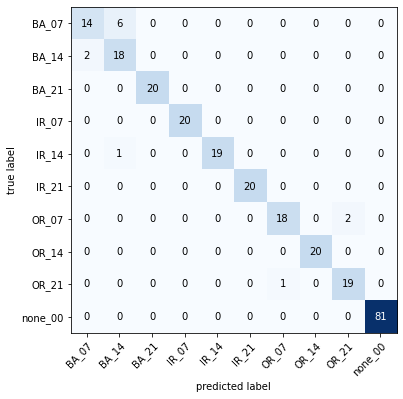

In [ ]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix(cm, figsize=(6, 6), show_absolute=True, show_normed=False, class_names=predictor.class_labels)

### 7 Modell Interpretation <a class="anchor" id="3_7"></a>
In der folgenden Zelle wird die sog. Merkmalswichtigkeit (engl.: feature importance) berechnet und aufgelistet (1. Spalte). Je höher die Wichtigkeit (importance), umso bedeutender und gewichtiger ist der Einfluss des jeweiligen Merkmals zur Bestimmung einer Vorhersage. Dies kann sehr aufschlussreich sein, um zu verstehen welche Merkmale eher wichtig und welche eher unwichtig sind.

In [ ]:
predictor.feature_importance(data_test, silent=True)

,importance,stddev,p_value,n,p99_high,p99_low
acc0_mean,0.262835,0.012591,6.300928e-07,5,0.288761,0.236910
acc1_min,0.183908,0.021842,2.343466e-05,5,0.228882,0.138934
acc0_min,0.170881,0.024623,5.032848e-05,5,0.221580,0.120183
acc1_max,0.114943,0.016480,4.934346e-05,5,0.148874,0.081011
acc0_max,0.114176,0.011301,1.136849e-05,5,0.137445,0.090907
acc0_median,0.022989,0.008128,1.599101e-03,5,0.039723,0.006254
acc0_range,0.013793,0.006411,4.290459e-03,5,0.026994,0.000592
acc1_range,0.010728,0.006854,1.244808e-02,5,0.024840,-0.003384
acc1_median,0.010728,0.009917,3.642753e-02,5,0.031148,-0.009692
acc1_mean,0.008429,0.003206,2.090536e-03,5,0.015029,0.001829


### 8 Modell exportieren/speichern <a class="anchor" id="3_8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern (optional unter Angabe eines Pfades der Wahl).

In [ ]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/Kugellager\")


### 9 Modell laden <a class="anchor" id="3_9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [ ]:
predictor = TabularPredictor.load(path="./AutogluonModels/Kugellager")

### 10 Vorhersagen für neue Daten <a class="anchor" id="3_10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [ ]:
test_window = data_features.sample()
test_window

,acc0_min,acc0_max,acc0_range,acc0_mean,acc0_median,acc1_min,acc1_max,acc1_range,acc1_mean,acc1_median,label
1138,-3.374996,3.301088,-3.374996,0.002744,0.005076,-0.977758,1.255533,-0.977758,0.031145,0.033284,OR_21


In [ ]:
prediction = predictor.predict(test_window)
print(f'Vorhergesagte Klasse: {", ".join(prediction.values)}')

Vorhergesagte Klasse: OR_21


## 3. Metallgussteile - Klassifikation mit Bilddaten <a class="anchor" id="4"></a>

Dieses Notebook ist ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von Bilddaten trainiert.
Ziel ist es, eine automatische Qualitätskontrolle für Metallgussteile zu entwickeln.
Dabei unterscheiden wir nur zwischen defekten und nicht defekten Gussteilen.

### Inhaltsverzeichnis
1. [Imports](#4_1)<br/>
2. [Laden der Daten](#4_2)<br/>
3. [Modell Training](#4_3)<br/>
4. [Modell Test](#4_4)<br/>
5. [Modell exportieren/speichern](#4_5)<br/>
6. [Modell laden](#4_6)<br/>
7. [Vorhersagen für neue Daten](#4_7)<br/>
8. [Aufgaben](#4_8)

### 1 Imports <a class="anchor" id="4_1"></a>
In diesem Beispiel verwenden wir das AutoML-Framework AutoGluon. Da es sich bei dem Datensatz um Bilder handelt, benötigen wir für die Bearbeitung des vorliegenden Problems die Klassen `ImageDataset` und `ImagePredictor`, welche wir hier importieren.

In [ ]:
from autogluon.vision import ImagePredictor, ImageDataset

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

### 2 Laden der Daten <a class="anchor" id="4_2"></a>

Der Datensatz enthält Bilder von Tauchpumpenlaufrädern aus Metallguss. Da während der Herstellung eine Vielzahl von Fehlern auftreten können, muss jedes Produkt einen Qualitätskontrollprozess durchlaufen. Diese (optische) Qualitätskontrolle kann durch maschinelles Lernen automatisiert werden, indem von jedem Erzeugnis ein Bild aufgenommen wird und dieses anschließend klassifiziert wird (Fehler oder kein Fehler).

<img src="../assets/Tauchpumpe mit Laufrad.jpg" alt="drawing" style="width:50%"/>

Weitere Informationen zum Datensatz sind unter foldendem Link zu finden: [https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

Über die Ordnerstruktur ist bereits festgelegt, welche der Bilder im Trainings- bzw. im Testset enthalten sind. In den jeweiligen Unterordnern "def_front" bzw. "ok_front" befinden sich die Bilder des entsprechenden Labels.

Wir laden die Daten mit Hilfe der `from_folders()` Methode der `ImageDataset` Klasse und speichern sie in den Variablen `train_data` und `test_Data`. Neben dem Ordnernamen müssen wir hierbei noch den Namen der jeweiligen Ordner mit den Trainings- bzw. Testdaten angeben. Mittels der `head()` Methode können wir uns die ersten 5 Instanzen des Trainingsdatensatzes anzeigen lassen.

In [ ]:
data_train, _, data_test = ImageDataset.from_folders('../data/Metallgussteile/', train='train', test='test')
print(f'Trainingsset: {len(data_train)} Bilder')
print(f'Testset: {len(data_test)} Bilder')
data_train.head()

Trainingsset: 6633 Bilder
Testset: 715 Bilder


,image,label
0,C:\Users\sbel\repositories\mdz-augsburg\datase...,0
1,C:\Users\sbel\repositories\mdz-augsburg\datase...,0
2,C:\Users\sbel\repositories\mdz-augsburg\datase...,0
3,C:\Users\sbel\repositories\mdz-augsburg\datase...,0
4,C:\Users\sbel\repositories\mdz-augsburg\datase...,0


In der folgenden Zelle nutzen wir die `show_images()` Methode, um jeweils vier Bilder der beiden Klassen zu visualisieren.

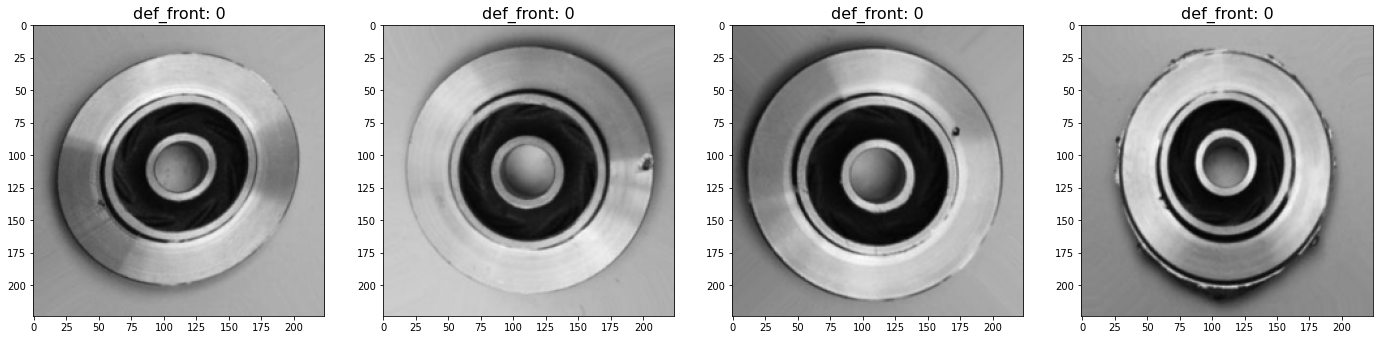

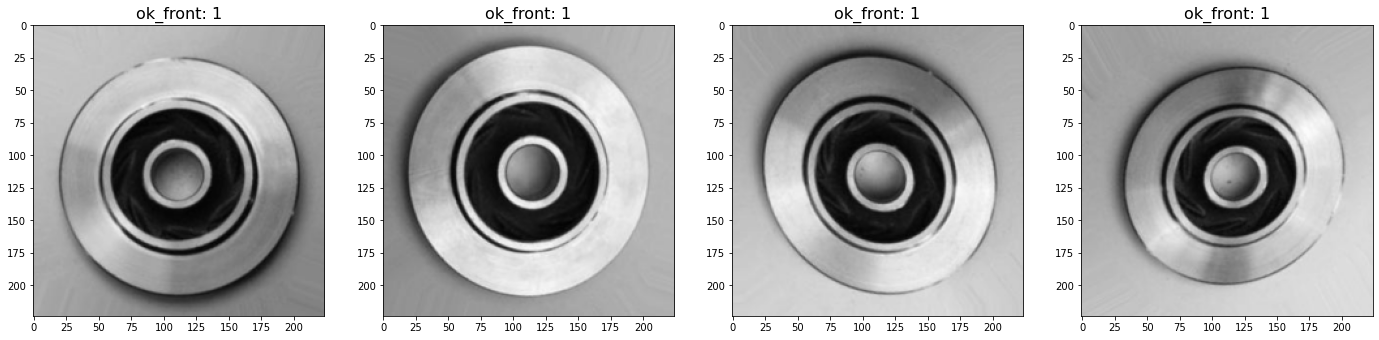

In [ ]:
data_train[data_train['label'] == 0].show_images(nsample=4, fontsize=16)
data_train[data_train['label'] == 1].show_images(nsample=4, fontsize=16)

Um das Training etwas zu beschleunigen, reduzieren wir die Datenmenge um 50%. Im Normalfall würde man davon absehen und die volle Datenmenge heranziehen, da somit auch ein besseres Modell zu erwarten ist. In diesem Beispiel Notebook wollen wir jedoch die Trainingszeit etwas auf Kosten der Genauigkeit reduzieren.

In [ ]:
fraction = 0.1
data_train = data_train.sample(frac=fraction)
data_test = data_test.sample(frac=fraction)
print(f'Trainingsset:\t{len(data_train)} Bilder')
print(f'Testset:\t{len(data_test)} Bilder')

Trainingsset:	663 Bilder
Testset:	72 Bilder


### 3 Modell Training <a class="anchor" id="4_3"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `ImagePredictor` und speichern diese in der Variablen `predictor`.
Optional kann man den Pfad angeben, in dem das Modell später gespeichert werden sollen (hier: "AutogluonModels/Metallgussteile").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>" erstellt, in dem das Modell später gespeichert wird.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten ein Modell.

! HINWEIS: Je nach definierter Datenmenge sowie CPU/GPU kann der Trainingsprozess sehr lange dauern !

In [ ]:
predictor = ImagePredictor(path='AutogluonModels/Metallgussteile')
predictor.fit(data_train, presets='medium_quality_faster_train')

Presets specified: ['medium_quality_faster_train']
Reset labels to [0, 1]
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Randomly split train_data into train[596]/validation[67] splits.
No GPU detected/allowed, using most conservative search space.
Starting fit without HPO
modified configs(<old> != <new>): {
root.gpus            (0,) != ()
root.img_cls.model   resnet101 != resnet50d
root.misc.seed       42 != 636
root.misc.num_workers 4 != 8
root.train.early_stop_baseline 0.0 != -inf
root.train.batch_size 32 != 64
root.train.epochs    200 != 50
root.train.early_stop_patience -1 != 5
root.train.early_stop_max_value 1.0 != inf
}
Saved config to C:\Users\sbel\repositories\mdz-augsburg\notebooks\AutogluonModels\Metallgussteile\e47d670f\.trial_0\config.yaml
Model resnet50d created, param count:                                         23531362
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
[Epoch 0] training: accu

### 4 Modell Test <a class="anchor" id="4_4"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.
Mit der `evaluate()` Methode können wir die Qualitätsmaße berechnen.

In [ ]:
pred_metrics = predictor.evaluate(data_test)

[Epoch 10] validation: top1=0.972222 top5=1.000000


Nun wollen wir uns etwas detailliertere Ergebnisse anschauen.

Dazu benutzen wir zunächst die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der Variable `y_pred`. Die tatsächlichen Label speichern wir in der Variable `y_true`.

In [ ]:
y_pred = predictor.predict(data_test)
y_true = data_test['label']

Mit Hilfe von `y_pred` und `y_true` können wir uns nun einen Klassifikations-Report ausgeben lassen. Dieser beinhaltet nicht nur die globale Genauigkeit (accuracy), sondern zeigt auch jeweils die Relevanz (precision), die Sensitivität (recall) sowie den F1-Score für die beiden Klassen im Datensatz an. Die support Spalte gibt an, wie viele Instanzen der jeweiligen Klasse sich im Testdatensatz befinden. 

In [ ]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       0.93      1.00      0.96        27

    accuracy                           0.97        72
   macro avg       0.97      0.98      0.97        72
weighted avg       0.97      0.97      0.97        72



Eine zusätzliche Möglichkeit, die Ergebnisse detailliert zu visualisieren bietet die sog. Konfusionsmatrix.
Entlang der x-Achse sehen wir die vom Modell gemachten Vorhersagen, auf der y-Achse die tatsächlichen Label.

Im Feld links oben (1. Zeile, 1. Spalte) steht also die Anzahl der Instanzen in den Traingsdaten, bei denen tatsächlich ein Defekt vorlag und dies von unserem Modell auch so vorhergesagt wurde.

Im Feld darunter (2. Zeile, 1. Spalte) steht die Anzahl der Instanzen, bei denen tatsächlich kein Defekt vorlag, unser Modell aber fälschlicherweise einen Defekt vorhergesagt hat, usw.

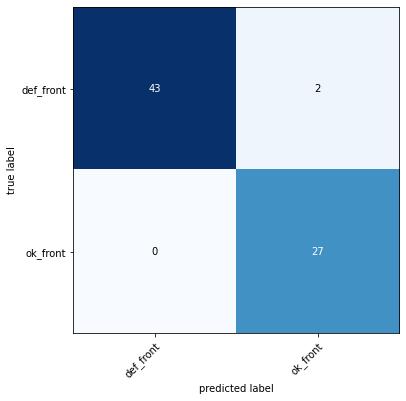

In [ ]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix(cm, figsize=(6, 6), show_absolute=True, show_normed=False, class_names=data_test.classes)

### 5 Modell exportieren/speichern <a class="anchor" id="4_5"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es zunächst gespeichert werden. Dies geschieht mittels der `save()` Methode.

In [ ]:
predictor.save()

### 6 Modell laden <a class="anchor" id="4_6"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode unter Angabe des gewünschten Pfades auf.

In [ ]:
predictor = ImagePredictor.load(path='./AutogluonModels/Metallgussteile')

### 7 Vorhersagen für neue Daten <a class="anchor" id="4_7"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [ ]:
test_img = data_test.sample() # eine zufällige Instanz wird aus dem Datensatz gezogen
test_img

,image,label
139,C:\Users\sbel\repositories\mdz-augsburg\datase...,0


In [ ]:
prediction = predictor.predict(test_img)
print(f'Vorhergesagte Klasse: {prediction.values[0]} ({data_train.classes[prediction.values[0]]})')

Vorhergesagte Klasse: 0 (def_front)
